## Final Project Submission

- Student Name: Adam Pell
- Student Pace: Self-Paced
- Scheduled project review date/time
- Instructor Name: Morgan Jones
- Blog Post URL:

# Overview

This project will use neural networks to analyze and predict the presence of pneumonia in pediatric chest X-rays.

Iterative analysis of thousands of healthy and unhealthy lung scans using deep learning yields predictive capabilities that may be accurate enough for supplemental or academic use. Our final model has an 88% accuracy rate, particularly excelling in the prediction of positive cases. Adding speed to routine diagnoses would be exceedingly helpful for any healthcare system, allowing doctors to deliver effective care to more patients and freeing up more time to focus on individual concerns or serious complications.

# Business Problem

Medicine is a cornerstone of society. Not only are advances in patient care vital to raising life expectancies worldwide, but they are essential to the global economy, representing more than 12 trillion dollars every year. 

Both in the United States and abroad, however, clinicians are facing a crisis. As doctors increasingly become spread more and more thin, they will need the assistants of advanced tools to correctly diagnose more patients in a timely manner. The model created in this project is a step towards making that a reality. This project will examine over 5500 X-rays from real pediatric patients, using deep learning techniques to extract key indicators of pneumonia and, through doing so, teach our models to "read" an X-ray just like a person would. Positive results could set the stage for a myriad of uses that range all the way from classrooms to hospitals.

# Data Understanding

The data for this project is a set of 5863 anterior-posterior chest X-ray images. They feature both healthy lungs and lungs that are infected with either viral or bacterial pneumonia. They are split into two subset and labeled "Normal" or "Pneumonia". The images come from cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center in China.

The images have also already been split into training, validation, and test sets, with the training set containing the vast majority of the images. The validation set is poorly constructed and only has 16 images, something we will adress during preprocessing.

Our target for this project will be optimizing the accuracy of our neural networks. In other words, we want our models to be able to accurately predict whether or not a given chest X-ray indicates pneumonia or not. Having the preset labels is handy, because we already know the true value of each image (e.g. whether or not the lung is healthy). The positive case today will be class 1, meaning that the patient in the image has pneumonia. The negative case will be class 0, or that the patient is healthy. 

There are no initial features to begin with here, as the model will be learning to read important parts of the images during training.

## Limitations

As is often the case, our dataset is fairly small and imbalanced. While the images are high-quality, there are not too many of them, especially when it comes to "Normal" images of healthy lungs.

This could affect our model's ability to generalize to unseen data. For medical images, extremely accurate generalization is especially important if machine learning models hope to be feasible for clinical use.

# Data Analysis

## Preparation

Before we dive into modeling, we will have to make sure the data is ready for our neural networks to process. The process for preparing image data has a few extra steps, as we need to essentially create a slightly augmented and formatted reproduction of our original images before we feed them into the network. The generation and augmentation process involves editing things like the size of the image (these models generally need uniform sizing). Optionally, we can add further augmentations such as random changes in zoom, skewing the images one way or the other, and even flipping images vertically or horizontally. This can add some more noise to the training data, sometimes improving outcomes. Since this is medical data, however, I want to refrain from making too many changes.

Another challenge facing us is the size of our validation set. While there are over 5000 images in our train set, our validation set is only 16 images. Since we are using backpropagation in our models, having inaccurate or otherwise wonky results on the validation set can hinder the model's self-improvement. We will want to draw a far larger sample for our validation data. My solution is to just split the large training set into 85% train and 15% validation.

Finally, we must also address the fairly-large class imbalance in the training data. While such imbalances are common in real-world data, it would be prefarable to even this dataset out a little bit so our model can't just get away with guessing one class over and over. We can do this in myriad ways, but I have chosen to experiment with downsampling the majority class and applying different class weights during training to artificially increase the importance of the minority class.

Below, I will go through a brief exploratory process before moving on to addressing our preprocessing challenges.

In [67]:
# Import relevant libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow
import os, shutil
from shutil import copyfile
import random
import tensorflow as tf
import scikeras
import seaborn as sns
import sympy
from sympy import symbols, Eq, solve
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, models
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from skimage.segmentation import mark_boundaries
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import scipy
from scipy import ndimage
from keras import models
from keras import layers
from keras import regularizers
from lime import lime_image
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

Since we can't just throw this data into pandas like we do for text or tabular data, we'll need to define some system paths so we can more easily navigate to and from image directories during preprocessing, training, and testing. Let's define some pathways below:

In [68]:
train_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train'
val_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/val'
test_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/test'

In [69]:
train_normal_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train/NORMAL'
train_pneumonia_dir = '/Users/adampell/Documents/Flatiron/phase-4/phase-4-project/data/chest_xray/train/PNEUMONIA'

Now that we've defined those pathways, let's create some quick functions to see what these images actually look like. Notice that, when we're loading these images, we actually have to open the file, load the image into a tensor, and then turn that tensor back into an image. Below, we can see visualization functions for both the normal and pneumonia images. The functions will return the index of any image the user inputs.

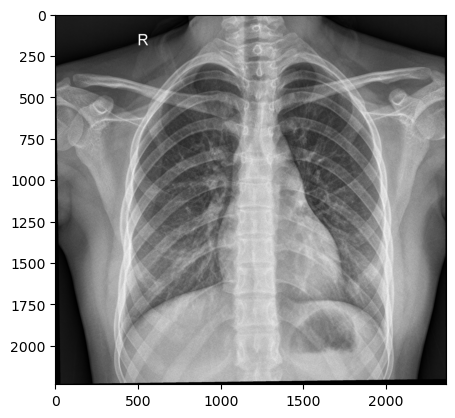

(2359, 2234)


In [70]:
def get_normal_image(number):
    normal_class_dir = os.path.join(train_dir, 'NORMAL')
    normal_train_file_list = os.listdir(normal_class_dir)
    normal_image_path = os.path.join(normal_class_dir, normal_train_file_list[number])
    
    image = Image.open(normal_image_path)
    image_array = np.array(image)

    # Display the image
    plt.imshow(image_array, cmap='gray')
    plt.show()
    print(image.size)
    
    
get_normal_image(0)

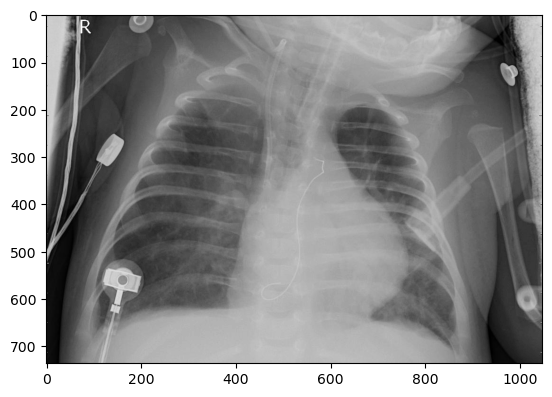

(1048, 736)


In [71]:
def get_pneumonia_image(number):
    pneumonia_class_dir = os.path.join(train_dir, 'PNEUMONIA')
    pneumonia_train_file_list = os.listdir(pneumonia_class_dir)
    pneumonia_image_path = os.path.join(pneumonia_class_dir, pneumonia_train_file_list[number])
    
    image = Image.open(pneumonia_image_path)
    image_array = np.array(image)

    # Display the image
    plt.imshow(image_array, cmap='gray')
    plt.show()
    print(image.size)
    
    
get_pneumonia_image(0)

To the untrained eye, it is difficult to see which lungs are infected and which are not. We will see if we can build a model to pick up on the telltale symptom of pneumonia: clouding of the lungs.

Let's get a better look at the class distribution of the train, validation, and test datasets:

In [72]:
def get_class_counts(directory):
    normal_class_dir = os.path.join(directory, 'NORMAL')
    normal_list = os.listdir(normal_class_dir)

    pneumonia_class_dir = os.path.join(directory, 'PNEUMONIA')
    pneumonia_list = os.listdir(pneumonia_class_dir)
    
    print(len(normal_list))
    print(len(pneumonia_list))

    print('Normal %: ', len(normal_list)/(len(normal_list) + len(pneumonia_list)))
    print('Pneumonia %: ', len(pneumonia_list)/(len(normal_list) + len(pneumonia_list)))

print('Training Class Counts:')
get_class_counts(train_dir)
print('')
print('Validation Class Counts:')
get_class_counts(val_dir)
print('')
print('Test Class Counts:')
get_class_counts(test_dir)

Training Class Counts:
1341
3875
Normal %:  0.2570935582822086
Pneumonia %:  0.7429064417177914

Validation Class Counts:
8
8
Normal %:  0.5
Pneumonia %:  0.5

Test Class Counts:
234
390
Normal %:  0.375
Pneumonia %:  0.625


As mentioned above, we see a fairly large class disparity in our training set, and, while our validation data is evenly distributed, there are only 16 images total. Let's create some data generators so we can experiment using different class distributions.

In this code, we are scaling the images down to values between 0 and 1 as opposed to their normal values between 0 and 256 as RGB images. Next, we are setting the directory the images are to be taken from and dictating the size we want the images to be when they are fed into the model. 512 seems to be the sweet spot between maintaining image quality and not bogging down training time with massive processing volume.

The block below creates a larger validation set by slicing some off images off a shuffled training set. Since only 16 images were in the original validation directory, we are not losing much data by doing it this way. These will serve as our base generators. Notice that our test generator still stands on its own, as it contains an adequate sample size. 

In [73]:
# Create an ImageDataGenerator with a validation split
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.15)

# Create generators for training and validation
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),  # The target size for our images
    batch_size=64,  # The batch size
    class_mode='binary',
    subset='training',  # Set the subset of data to training
    shuffle=True)

validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(512, 512),
    batch_size=64,
    class_mode='binary',
    subset='validation',  # Set the subset of data to validation
    shuffle=True)

test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(512,512),
    batch_size=64, class_mode='binary', shuffle=False)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


Let's take a look at a sample image that comes out of this generator. You might notice that, at 512x512, the quality may be slightly worse than our crisp images with pixel counts in the thousands. Nevertheless, though, it still looks good enough that small aberrations would be visible to the model. In other words, it will still be able to pick up on small nuances and indicators in each image despite the slight decrease in quality.

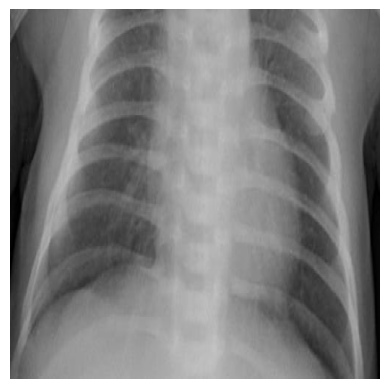

In [74]:
images, labels = next(train_generator)

# Extract a single image from the batch
image = images[0]

# Plot the image
plt.imshow(image)
plt.axis('off')  # Hide the axes for better visualization
plt.show()

Now that we've visualized our data and created our generators, we can move onto building some neural networks!

## Preliminary Modeling

This is where our iterative modeling process begins. Each model will be increasingly complex, with complexity in this case being defined by how many trainable parameters we are dealing with. Additionally, we will be adding optimization techniques such as dropout layers to prevent overfitting. Our later models will be convolutional neural networks, which feature convoluting and pooling layers that reduce the dimensionality of the image data before feeding into normal dense neuron layers. Finally, we will implement transfer learning using MobileNet V2, a CNN with 53 layers that has been trained on over a million images of all kinds. It is often the case that using these models to fit our dataset will yield sueprior results to our base training alone.

Our target metric will be **accuracy**. However, given the nature of the field we are researching, we will also have to be mindful of false positives and false negatives, as high rates of either could have cascading real-world consequences. We will be able to visualize model performance in several ways. These include graphing model loss and performance gains over training epochs. As the models get more complex, it may also be beneficial to visualize the model architectures and activation functions we are using. 

We will begin below with a baseline, vanilla model with only a couple hidden layers:

In [75]:
baseline_model = Sequential()

baseline_model.add(Flatten(input_shape=(512, 512, 3)))
baseline_model.add(Dense(256, activation='relu'))
baseline_model.add(Dense(128, activation='relu'))
baseline_model.add(Dense(1, activation='sigmoid'))

baseline_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

baseline_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 786432)            0         
                                                                 
 dense_21 (Dense)            (None, 256)               201326848 
                                                                 
 dense_22 (Dense)            (None, 128)               32896     
                                                                 
 dense_23 (Dense)            (None, 1)                 129       
                                                                 
Total params: 201359873 (768.13 MB)
Trainable params: 201359873 (768.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Above we see our model summary. There are about 200 million parameters, which isn't huge in the grand scheme of things. We only have a couple hidden layers here between the input and output layers, and we are using fairly standard activation functions and optimizers. Remember, since we have a class imbalance, we are going to try weighting the minority class to penalize the model more for wrong guesses relating to that class. Let's see how we do:

In [76]:
class_weights_baseline = {0 : 2, 1 : 1}

history_baseline = baseline_model.fit(
    train_generator, 
    epochs=20, 
    batch_size=64, 
    validation_data=validation_generator,
    class_weight=class_weights_baseline,
    verbose=1)

Epoch 1/20
70/70 [==============================] - 27s 385ms/step - loss: 52.4742 - accuracy: 0.8142 - val_loss: 48.3290 - val_accuracy: 0.8274
Epoch 2/20
70/70 [==============================] - 27s 383ms/step - loss: 23.0303 - accuracy: 0.8893 - val_loss: 30.9960 - val_accuracy: 0.8325
Epoch 3/20
70/70 [==============================] - 27s 388ms/step - loss: 22.8290 - accuracy: 0.8784 - val_loss: 12.9514 - val_accuracy: 0.9015
Epoch 4/20
70/70 [==============================] - 28s 394ms/step - loss: 15.6808 - accuracy: 0.9057 - val_loss: 7.8767 - val_accuracy: 0.9169
Epoch 5/20
70/70 [==============================] - 28s 399ms/step - loss: 9.6226 - accuracy: 0.9323 - val_loss: 19.5575 - val_accuracy: 0.8453
Epoch 6/20
70/70 [==============================] - 28s 402ms/step - loss: 24.2906 - accuracy: 0.8733 - val_loss: 8.3715 - val_accuracy: 0.9258
Epoch 7/20
70/70 [==============================] - 28s 401ms/step - loss: 17.7235 - accuracy: 0.9114 - val_loss: 8.8733 - val_accura

In [79]:
true_labels_baseline = test_generator.classes
predicted_probabilities_baseline = baseline_model.predict(test_generator)
predicted_labels_baseline = predicted_probabilities_baseline > 0.5

10/10 [==============================] - 3s 246ms/step


In [80]:
baseline_report = classification_report(true_labels_baseline, predicted_labels_baseline, target_names=['Normal', 'Pneumonia'])
print(baseline_report)

              precision    recall  f1-score   support

      Normal       0.97      0.25      0.39       234
   Pneumonia       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.62      0.60       624
weighted avg       0.79      0.71      0.66       624



Let's break this down a little. Overall, we get an accuracy of 77%. Not terrible for our first attempt, but certainly plenty to be desired. After all, a model that solely guesses that every image is pneumonia would actually be right 74% of the time! We need to see some improvements, especially in recall for 'Normal' images. At 42%, this model would be predicting a lot of false positives, misleading healthcare professionals and possibly leading to incorrect care. We certainly would like to even out predictions so there's not a preponderance of one class or the other.

We can check out the loss progression below along with a confusion matrix for the test set where we can see exactly how many images were correctly or incorrectly identified:

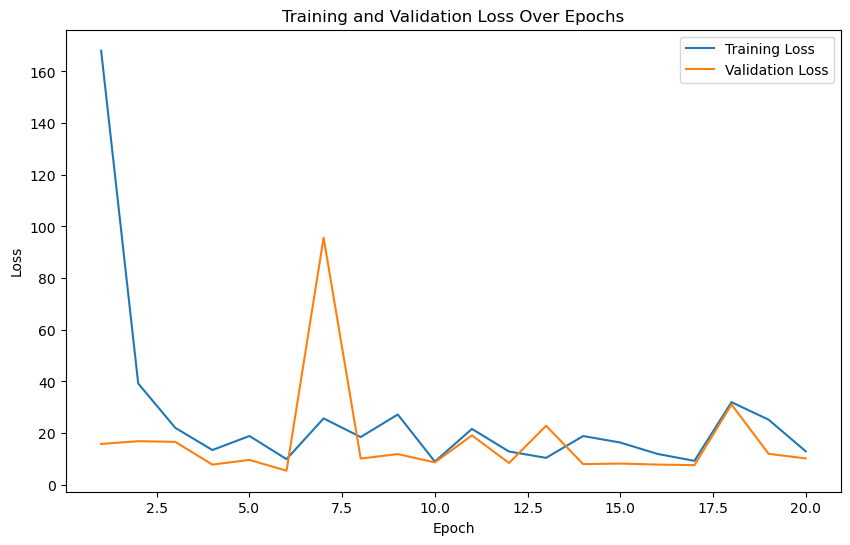

In [14]:
baseline_train_loss = history_baseline.history['loss']
baseline_val_loss = history_baseline.history['val_loss']

epoch_count = range(1, len(baseline_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, baseline_train_loss)
plt.plot(epoch_count, baseline_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

This chart seems a little jagged and not very smooth across epochs. I think there are two main factors at play:
   - **Learning rate:** Sometimes, a learning rate that is too high will essentially cause a model to overshoot optimal parameters during training runs. We can alter this learning rate in future runs if necessary.
   - **Low number of epochs:** We only ran 20 epochs for training here, so this graph could just be explained by the model not having enough time to even out the loss.
   
The confusion matrix below can shed a little more light on where the model's strengths and weaknesses lie:

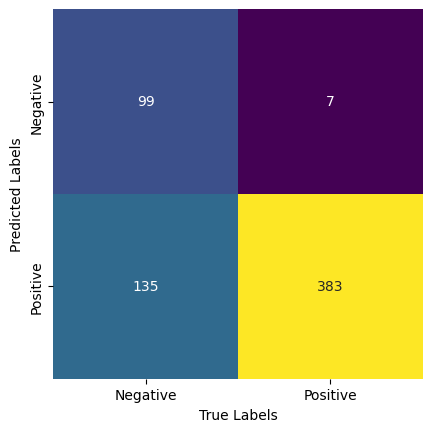

In [17]:
baseline_mat = confusion_matrix(true_labels_baseline, predicted_labels_baseline)
sns.heatmap(baseline_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

As we can see, the model is doing great at predicting cases with pneumonia. However, for patients without pneumonia, we're getting a lot of false positives. While the model only diagnosed 7 false negatives, it diagnosed 135 false positives. 

In our next model, I am going to add more dense layers and introduce dropout layers, which will randomly remove neurons from the network. This is an effort to prevent overfitting. This will be needed because, as we saw above, our first model was achieving excellent performance on the training and even the validation set, only to find middling success on unseen data.

In [17]:
dropout_model = Sequential()

dropout_model.add(Flatten(input_shape=(512, 512, 3)))
dropout_model.add(Dense(256, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(128, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(64, activation='leaky_relu'))
dropout_model.add(Dropout(0.5))
dropout_model.add(Dense(1, activation='sigmoid'))

dropout_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

dropout_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               201326848 
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_5 (Dropout)         (None, 64)               

Much of our model's structure is the same. We introduce an additional dense layer to filter our inputs through, and we add dropout layers in between each dense layer. Our optimizer remains the same as before. Since we will be running this model for more epochs than the last one, I've also introduced an early stopping mechanism. This will automatically end the run if no loss improvements are made for 10 straight epochs. If it has to stop the run early, it will take the weights from the best run and store those for when we make our predictions. This is another measure to prevent overfitting. Accurate generalization is vital for this model if it is to assist physicians in assessing thousands or even millions of lung X-rays in the future.

In [18]:
early_stopping_dropout = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

class_weights_dropout = {0 : 2, 1 : 1}

history_dropout = dropout_model.fit(
    train_generator,
    epochs=45,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping_dropout],
    class_weight=class_weights_dropout,
    verbose=1)

Epoch 1/45
70/70 [==============================] - 28s 396ms/step - loss: 107.1104 - accuracy: 0.6655 - val_loss: 22.0849 - val_accuracy: 0.5294
Epoch 2/45
70/70 [==============================] - 27s 390ms/step - loss: 26.3842 - accuracy: 0.7986 - val_loss: 30.2513 - val_accuracy: 0.5908
Epoch 3/45
70/70 [==============================] - 28s 400ms/step - loss: 19.6196 - accuracy: 0.8182 - val_loss: 20.4348 - val_accuracy: 0.6036
Epoch 4/45
70/70 [==============================] - 28s 404ms/step - loss: 12.1390 - accuracy: 0.8568 - val_loss: 3.6388 - val_accuracy: 0.8670
Epoch 5/45
70/70 [==============================] - 28s 401ms/step - loss: 9.5542 - accuracy: 0.8597 - val_loss: 8.6582 - val_accuracy: 0.7506
Epoch 6/45
70/70 [==============================] - 28s 403ms/step - loss: 6.6934 - accuracy: 0.8848 - val_loss: 4.8453 - val_accuracy: 0.8184
Epoch 7/45
70/70 [==============================] - 29s 413ms/step - loss: 5.8365 - accuracy: 0.8836 - val_loss: 5.8734 - val_accuracy

In [20]:
true_labels_dropout = test_generator.classes
predicted_probabilities_dropout = dropout_model.predict(test_generator)
predicted_labels_dropout = predicted_probabilities_dropout > 0.5

10/10 [==============================] - 3s 267ms/step


In [21]:
dropout_report = classification_report(true_labels_dropout, predicted_labels_dropout, target_names=['Normal', 'Pneumonia'])
print(dropout_report)

              precision    recall  f1-score   support

      Normal       0.88      0.49      0.63       234
   Pneumonia       0.76      0.96      0.85       390

    accuracy                           0.78       624
   macro avg       0.82      0.72      0.74       624
weighted avg       0.80      0.78      0.77       624



Here we see modest improvements to our target metric, but we have a lot to be desired. It seems that we have essentially traded some precision for recall in our negative class, which seems to have at least translated to higher cumulative performance. Our model did stop early, meaning that it stopped improving on itself after 11 epochs. So, the optimal parameters here were achieved with only one additional epoch compared to our first model.

Let's take a look at the loss graph:

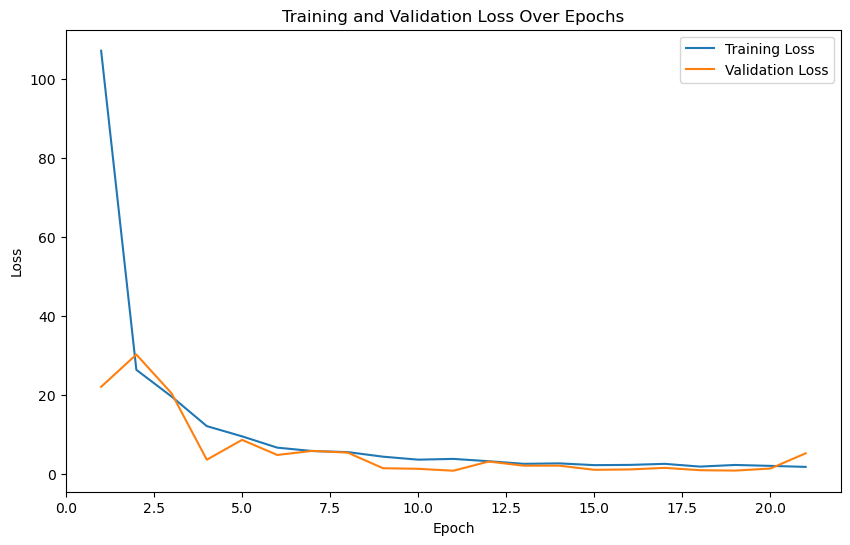

In [24]:
dropout_train_loss = history_dropout.history['loss']
dropout_val_loss = history_dropout.history['val_loss']

epoch_count = range(1, len(dropout_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, dropout_train_loss)
plt.plot(epoch_count, dropout_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

A positive is that we see a smoother decline here, meaning that our learning rate seemed about right for this model, especially considering we only actually ran, basically, the same amount of epochs as our first model. We can actually see where we reached our optimal parameters as the orange line bottoms out at epoch 11.

Let's take a closer look at the confusion matrix for this model:

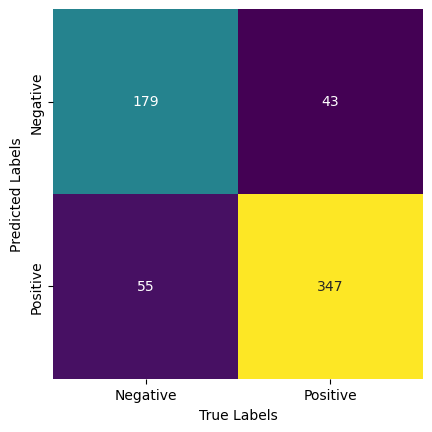

In [25]:
dropout_mat = confusion_matrix(true_labels_dropout, predicted_labels_dropout)
sns.heatmap(dropout_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

The look of this matrix reinforces the idea that we've had a bit of a tradeoff in performance which has led to the marginal accuracy gain. Our false positive rate has improved immensely, with only 55 incorrect predictions there. However, our false negative rate has suffered, almost quintupling from its original value in the first model. We maintain a stellar rate of true positive predictions, and the highlight of the graph has moved from the bottom left to the top left, further indicating a large shift in prediction capabilites for the negative case.

We can also visualize activations in individual neurons. By switching from ReLu to leaky ReLu, I'm hoping to ensure that neurons stay "alive" across layers. Leaky ReLu can sometimes help converge on those optimal loss parameters better, so I'm not surprised that performance is better.

2/2 [==============================] - 0s 68ms/step


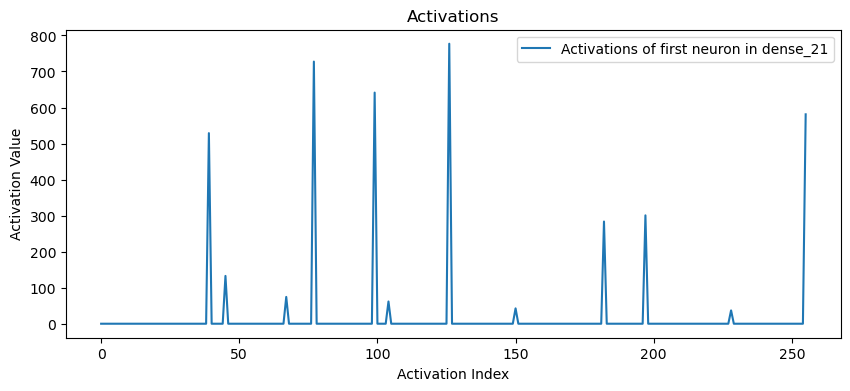

In [88]:
layer_name = 'dense_21' 
intermediate_layer_model = Model(inputs=baseline_model.input,
                                 outputs=baseline_model.get_layer(layer_name).output)

# Select some data to pass through the model
data_samples, labels = next(train_generator)

# Get the output of the layer
activations = intermediate_layer_model.predict(data_samples)

# Now plot the activations of the first neuron as an example
plt.figure(figsize=(10, 4))
plt.plot(activations[16], label=f'Activations of first neuron in {layer_name}')
plt.title('Activations')
plt.xlabel('Activation Index')
plt.ylabel('Activation Value')
plt.legend()
plt.show()

2/2 [==============================] - 2s 2s/step


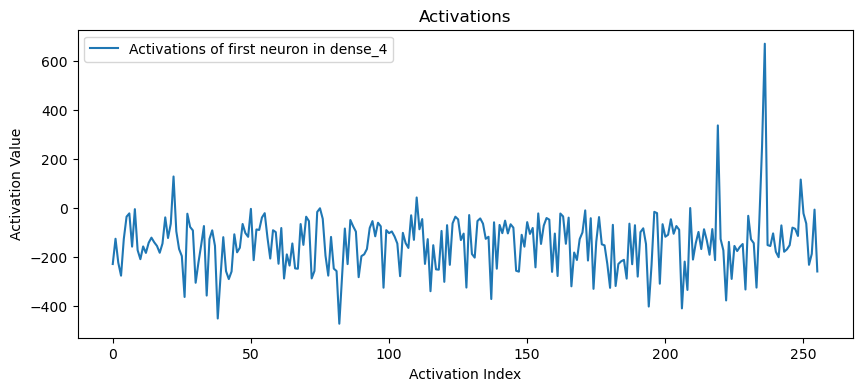

In [89]:
layer_name = 'dense_4' 
intermediate_layer_model = Model(inputs=dropout_model.input,
                                 outputs=dropout_model.get_layer(layer_name).output)

# Select some data to pass through the model
data_samples, labels = next(train_generator)

# Get the output of the layer
activations = intermediate_layer_model.predict(data_samples)

# Now plot the activations of the first neuron as an example
plt.figure(figsize=(10, 4))
plt.plot(activations[16], label=f'Activations of first neuron in {layer_name}')
plt.title('Activations')
plt.xlabel('Activation Index')
plt.ylabel('Activation Value')
plt.legend()
plt.show()

Overall, we are moving in the right direction. Thus far, we've been using more "vanilla" networks in multilayer perceptrons (or MLPs). Let's see if we can take our predictions to the next level using a convolutional neural network (CNN) architecture, which learns in a different way that is generally more conducive to image analysis.

In [90]:
# Define the CNN model
cnn_model = Sequential()

# Convolutional layer block 1 with Batch Normalization
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(512, 512, 3)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer block 2
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolutional layer block 3
cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten before passing to the dense layers
cnn_model.add(Flatten())

# Dense layers
cnn_model.add(Dense(128, activation='leaky_relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(64, activation='leaky_relu'))
cnn_model.add(Dropout(0.5))

# Output layer
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
cnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 255, 255, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 124, 124, 32)      18464     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 62, 62, 32)       

Notice that this model has a lot more layers than our previous ones. That is because, for this architecture, we need to employ convolutional and pooling layers. Convolutional layers move like a sliding window over the image, magnifying small bundles of pixels and creating a feature map. Pooling layers take each grid from the convolutional layers and picks the most important value from each one. In this way, these layers can detect features at different levels of abstraction than a normal neural network. This makes it a great tool for object detection and feature recognition.

In [91]:
early_stopping_cnn = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min', restore_best_weights=True)

class_weights_cnn = {0 : 2.5, 1 : 1}

history_cnn = cnn_model.fit(
    train_generator,
    epochs=60,
    batch_size=64,
    validation_data=validation_generator,
    callbacks=[early_stopping_cnn],
    class_weight=class_weights_cnn,
    verbose=1)

Epoch 1/60
70/70 [==============================] - 48s 631ms/step - loss: 0.8461 - accuracy: 0.7244 - val_loss: 0.5217 - val_accuracy: 0.7992
Epoch 2/60
70/70 [==============================] - 39s 550ms/step - loss: 0.5256 - accuracy: 0.8764 - val_loss: 0.3998 - val_accuracy: 0.8197
Epoch 3/60
70/70 [==============================] - 41s 573ms/step - loss: 0.3892 - accuracy: 0.8978 - val_loss: 0.3219 - val_accuracy: 0.8632
Epoch 4/60
70/70 [==============================] - 40s 557ms/step - loss: 0.3028 - accuracy: 0.9253 - val_loss: 0.2578 - val_accuracy: 0.8939
Epoch 5/60
70/70 [==============================] - 41s 581ms/step - loss: 0.2541 - accuracy: 0.9393 - val_loss: 0.2335 - val_accuracy: 0.9015
Epoch 6/60
70/70 [==============================] - 41s 583ms/step - loss: 0.2374 - accuracy: 0.9393 - val_loss: 0.2529 - val_accuracy: 0.8939
Epoch 7/60
70/70 [==============================] - 41s 574ms/step - loss: 0.2171 - accuracy: 0.9450 - val_loss: 0.1702 - val_accuracy: 0.9309

Error: command buffer exited with error status.
	The Metal Performance Shaders operations encoded on it may not have completed.
	Error: 
	(null)
	Internal Error (0000000e:Internal Error)
	<AGXG14XFamilyCommandBuffer: 0x30e3dfc20>
    label = <none> 
    device = <AGXG14CDevice: 0x104db4c00>
        name = Apple M2 Max 
    commandQueue = <AGXG14XFamilyCommandQueue: 0x2e29ab800>
        label = <none> 
        device = <AGXG14CDevice: 0x104db4c00>
            name = Apple M2 Max 
    retainedReferences = 1


70/70 [==============================] - 42s 586ms/step - loss: 0.1216 - accuracy: 0.9705 - val_loss: 0.1362 - val_accuracy: 0.9412
Epoch 20/60
70/70 [==============================] - 41s 579ms/step - loss: 0.1134 - accuracy: 0.9702 - val_loss: 0.1577 - val_accuracy: 0.9412
Epoch 21/60
70/70 [==============================] - 41s 576ms/step - loss: 0.1214 - accuracy: 0.9684 - val_loss: 0.1202 - val_accuracy: 0.9463
Epoch 22/60
70/70 [==============================] - 40s 565ms/step - loss: 0.1178 - accuracy: 0.9718 - val_loss: 0.1877 - val_accuracy: 0.9207
Epoch 23/60
70/70 [==============================] - 40s 568ms/step - loss: 0.1114 - accuracy: 0.9709 - val_loss: 0.1337 - val_accuracy: 0.9463
Epoch 24/60
70/70 [==============================] - 40s 566ms/step - loss: 0.1080 - accuracy: 0.9736 - val_loss: 0.1280 - val_accuracy: 0.9463
Epoch 25/60
70/70 [==============================] - 40s 567ms/step - loss: 0.1028 - accuracy: 0.9734 - val_loss: 0.1751 - val_accuracy: 0.9335
Epoc

In [92]:
true_labels_cnn = test_generator.classes
predicted_probabilities_cnn = cnn_model.predict(test_generator)
predicted_labels_cnn = predicted_probabilities_cnn > 0.5

10/10 [==============================] - 4s 356ms/step


In [93]:
cnn_report = classification_report(true_labels_cnn, predicted_labels_cnn, target_names=['Normal', 'Pneumonia'])
print(cnn_report)

              precision    recall  f1-score   support

      Normal       0.99      0.40      0.57       234
   Pneumonia       0.73      1.00      0.85       390

    accuracy                           0.77       624
   macro avg       0.86      0.70      0.71       624
weighted avg       0.83      0.77      0.74       624



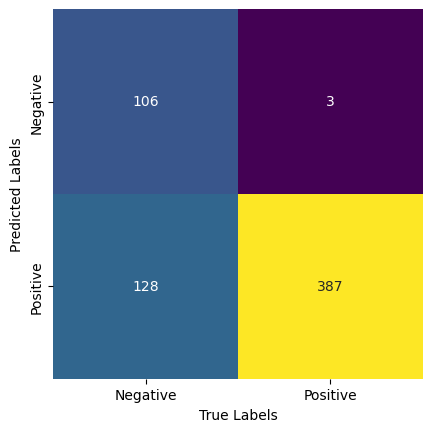

In [30]:
cnn_mat = confusion_matrix(true_labels_cnn, predicted_labels_cnn)
sns.heatmap(cnn_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

## Final Model

In [31]:
mobilenet_train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # The target size for your images
    batch_size=64,  # The batch size
    class_mode='binary',
    subset='training',  # Set the subset of data to training
    shuffle=True)

mobilenet_validation_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    subset='validation',  # Set the subset of data to validation
    shuffle=True)

mobilenet_test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=64, class_mode='binary', shuffle=False)

Found 4434 images belonging to 2 classes.
Found 782 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [98]:
mobilenet = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
mobilenet.trainable = False  # Freeze the convolutional base

# Create a new model on top
transfer_model = Sequential()

transfer_model.add(mobilenet)
transfer_model.add(GlobalAveragePooling2D())

transfer_model.add(Dense(64, activation='leaky_relu'))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(1, activation='sigmoid'))

# Compile the model
transfer_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

transfer_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_30 (Dense)            (None, 64)                81984     
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_31 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2340033 (8.93 MB)
Trainable params: 820

In [99]:
transfer_early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1, mode='min', restore_best_weights=True)

transfer_class_weights = {0 : 2.5, 1 : 1}

transfer_history = transfer_model.fit(
    mobilenet_train_generator,
    steps_per_epoch=mobilenet_train_generator.n // mobilenet_train_generator.batch_size,
    epochs=10,
    validation_data=mobilenet_validation_generator,
    validation_steps=mobilenet_validation_generator.n // mobilenet_validation_generator.batch_size,
    callbacks=[transfer_early_stopping],
    class_weight=transfer_class_weights,
    verbose=1)

Epoch 1/10
69/69 [==============================] - 25s 340ms/step - loss: 1.3827 - accuracy: 0.3458 - val_loss: 0.7686 - val_accuracy: 0.4089
Epoch 2/10
69/69 [==============================] - 23s 333ms/step - loss: 1.1026 - accuracy: 0.5025 - val_loss: 0.6094 - val_accuracy: 0.7005
Epoch 3/10
69/69 [==============================] - 23s 338ms/step - loss: 0.9499 - accuracy: 0.6137 - val_loss: 0.5272 - val_accuracy: 0.8268
Epoch 4/10
69/69 [==============================] - 23s 336ms/step - loss: 0.8490 - accuracy: 0.6755 - val_loss: 0.4741 - val_accuracy: 0.8646
Epoch 5/10
69/69 [==============================] - 23s 337ms/step - loss: 0.7444 - accuracy: 0.7465 - val_loss: 0.4299 - val_accuracy: 0.8841
Epoch 6/10
69/69 [==============================] - 23s 336ms/step - loss: 0.6674 - accuracy: 0.7938 - val_loss: 0.4023 - val_accuracy: 0.8828
Epoch 7/10
69/69 [==============================] - 23s 337ms/step - loss: 0.6051 - accuracy: 0.8256 - val_loss: 0.3745 - val_accuracy: 0.8828

In [100]:
predicted_probabilities_transfer = transfer_model.predict(mobilenet_test_generator)
predicted_labels_transfer = predicted_probabilities_transfer > 0.5

10/10 [==============================] - 3s 214ms/step


In [101]:
mobilenet_true_labels = mobilenet_test_generator.classes
transfer_report = classification_report(mobilenet_true_labels, predicted_labels_transfer, target_names=['Normal', 'Pneumonia'])
print(transfer_report)

              precision    recall  f1-score   support

      Normal       0.85      0.74      0.79       234
   Pneumonia       0.86      0.92      0.89       390

    accuracy                           0.86       624
   macro avg       0.86      0.83      0.84       624
weighted avg       0.86      0.86      0.85       624



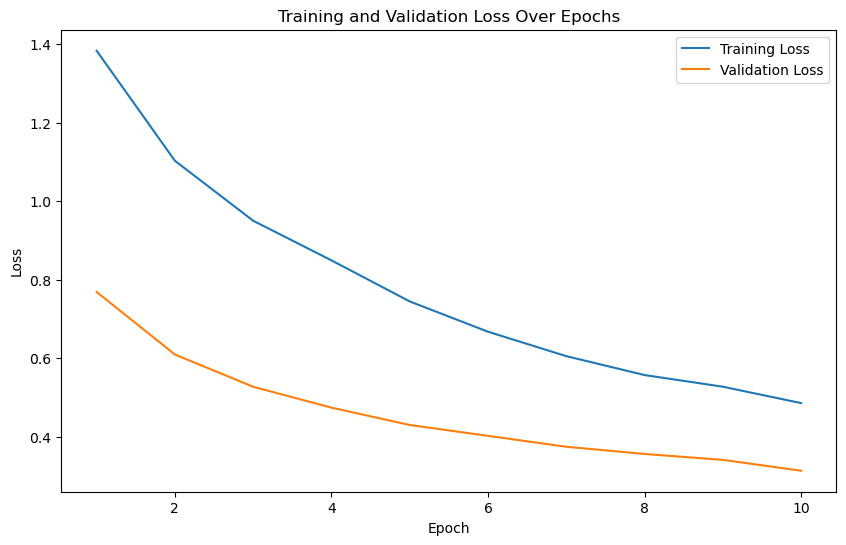

In [102]:
transfer_train_loss = transfer_history.history['loss']
transfer_val_loss = transfer_history.history['val_loss']

epoch_count = range(1, len(transfer_train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epoch_count, transfer_train_loss)
plt.plot(epoch_count, transfer_val_loss)
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.show()

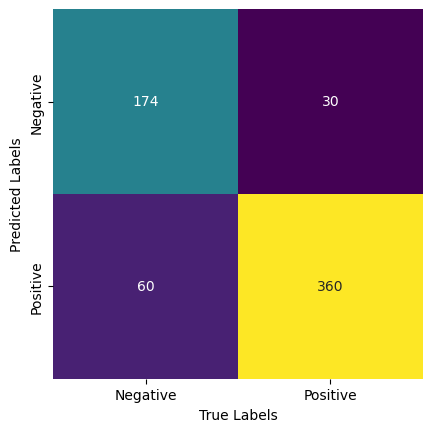

In [103]:
transfer_mat = confusion_matrix(mobilenet_true_labels, predicted_labels_transfer)
sns.heatmap(transfer_mat.T, square=True, annot=True, fmt='d', cbar=False, cmap='viridis',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.show()

This model delivers the best performance yet, but there is still plenty to be desired, especially in the persistent problem area of false positives. 

# Conclusions

Our iterative modeling process has yielded a model with solid performance gains and generalization capabilities. Using transfer learning was the most effective tool, achieving 86% accuracy and a huge bump in recall for the negative class. As the our final confusion matrix confirms, we are really starting to move the needle on false positives, which has proved problematic throughout. We have maintained excellent recall on the positive case, meaning our false negatives remain quite low overall.

While the model may not yet be ready for heavy use in a clinical setting, the foundation is there and it looks very promising. With larger datasets and more fine-tuning methods, our model could one day save physicians and patients precious time by quickly and accurately diagnosing a common yet potentiall deadly illness.

Based on this project's findings, our recommendations are:
- Limit clinical use without strict supervision
- Use as second opinion for suspected positive cases
- Use for physician training

Our recommendations focus on this model's use within a larger supervised structure, as it is not accurate enough to be trusted alone. In the hands of a skilled medical staff, however, it can be a powerful tool, especially when pneumonia is already suspected. It can also be used in medical schools or for resident training, as it could prove a quick and effective way to test a trainee's ability to read chest X-rays themselves.

## Next Steps

While our model is performing well, many improvements can still be made. Namely, more data is vital to achieving better generalization outcomes, as we have shown a consistent ability to optimize for loss using various architectures. Seeing a larger variety of X-rays and more presentations of sick and healthy lungs would allow for large leaps in predictive capabilites on unseen data. Further analysis could include:

- Prediction explainability using LIME
- Complex CNNs that require more compute
- Image augmentation during training

## Contact Information

- Email: apell7591@gmail.com
- Phone: 917-434-6615
- GitHub: apell7594
- LinkedIn: Adam Pell